In [1]:
import numpy as np
import os
import pandas as pd
import torch
import clip

from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import json
import sys
sys.path.insert(0, '../')
import utils as ut
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline
import pickle
import importlib
import pandas as pd
import ast
import math
from scipy import stats
import idenProf as IP
import copy

In [2]:
importlib.reload(IP)
importlib.reload(ut)

<module 'utils' from '/mnt/efs/fairclip/FinalCode/IdenProf/../utils.py'>

In [3]:
device = "cuda:0" #if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=device)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [4]:
def get_features(dataset, model):
    all_features = []
    all_img_paths = []
    all_professions = []

    with torch.no_grad():
        for images, img_path, professions in tqdm(DataLoader(dataset, batch_size=100)):
#             print(images.shape)
            features = model.encode_image(images.to(device)).to(device, dtype=torch.float32)
            
                
            all_features.append(features)
            all_img_paths.append(img_path)
            all_professions.append(professions)
            

    return torch.cat(all_features), np.concatenate(all_img_paths),\
            np.concatenate(all_professions)


In [5]:
iden_prof = IP.MyIdentProf("../../idenprof/train", preprocess)

In [6]:
all_features_test, all_img_paths, all_professions = get_features(iden_prof, model)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [01:02<00:00,  1.45it/s]


In [7]:
all_features_test /= all_features_test.norm(dim=-1, keepdim=True)

In [8]:
# CLIP 
#'firefighter',
queries = [ 'chef', 'doctor', 'engineer', 'farmer',  \
               'judge', 'mechanic','law enforcement officer', 'pilot',   'server']
text_tokens = clip.tokenize(["a photo of a " + desc for desc in queries]).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()

text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * all_features_test @ text_features.T).cpu().numpy().astype(np.float64).T

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.io as io
import PIL.Image

In [10]:
precision_10 = {}
precision_20 = {}
precision_30 = {}
num_acc_10 = {}
num_acc_20 = {}
num_acc_30 = {}

server
0.90


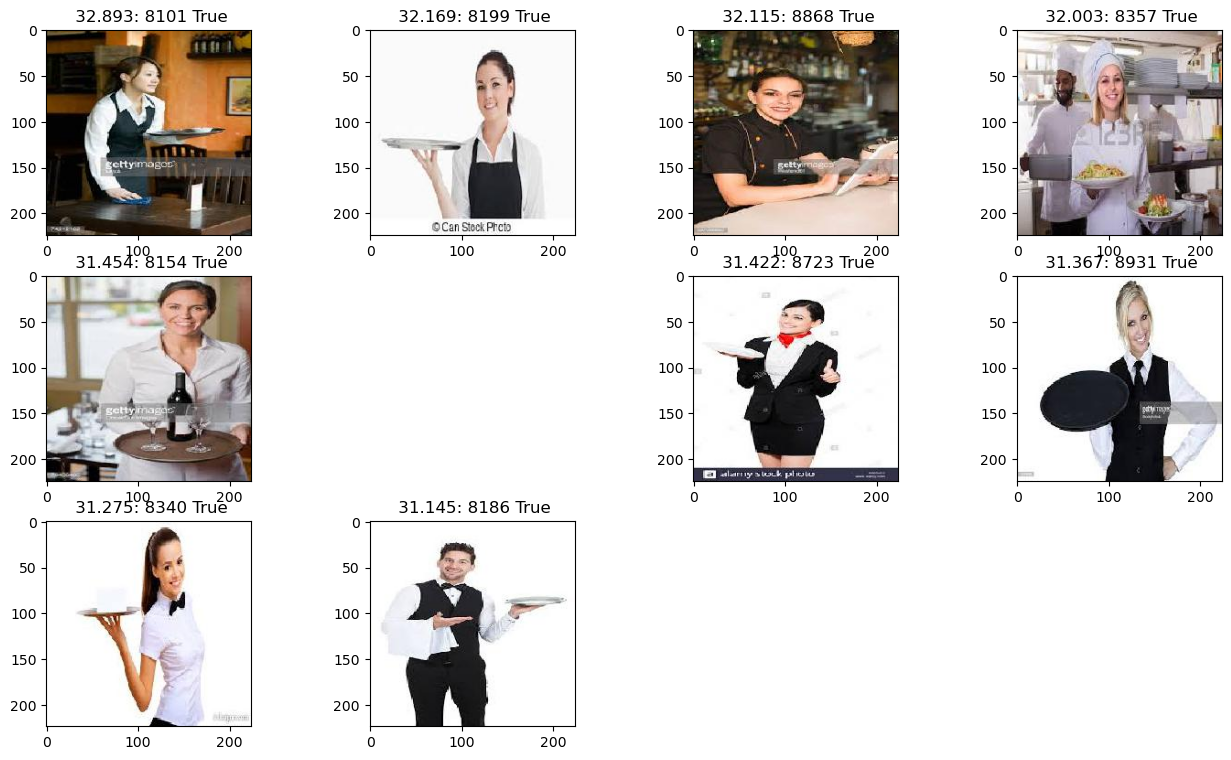

In [39]:
query_dict = {}
profs = copy.deepcopy(iden_prof.professions)
profs.remove('firefighter')
for  k, s in enumerate(similarity):
    

#     print(s)
#     s = np.asarray(similarity[k])
#     s = np.asarray(s)
#     print(queries[k])
    query_dict[queries[k]] = s #similarity[k]
topk = 10
sorted_idx = []
for k in query_dict.keys():

    s = np.asarray(query_dict[k])
    ind = s.argsort()[-topk:][::-1]
    sorted_idx.append(ind)    



for q_idx, (k, s_ind) in enumerate(zip(query_dict.keys(), sorted_idx)):
    if q_idx == 8:
        
        s = np.asarray(query_dict[k])
        print(queries[q_idx])
    #     print("top 10", s[s_ind])
        plt.figure(figsize=(16, 25))
        acc = 0
        for topi, idx in enumerate(s_ind):
            
            a = iden_prof[idx][2]
#             print(a, profs[q_idx])
            acc += int(profs[q_idx]== a)
            
            if profs[q_idx] != a:
                continue
            plt.subplot(8, 4, topi + 1 )
            
#             print(profs[q_idx])
            image = io.imread( iden_prof[idx][1])
            pil_image = PIL.Image.fromarray(image)
            plt.imshow(pil_image)
            plt.title(f" {s[s_ind[topi]]:.3f}: {idx} {profs[q_idx]== a}")
        print(f'{acc/topk:.2f}')
        if topk==10:
           
            precision_10[q_idx] = acc/topk
        elif topk==20:
            precision_20[q_idx] = acc/topk
        else:
#             print(topk)
            precision_30[q_idx] = acc/topk

In [41]:
# avg_p = 0
# for k, p in precision_10.items():
#     print(p)
# del precision_10[4]

print(f'{np.mean(list(precision_10.values())):.2f} \u00B1 {stats.sem(list(precision_10.values()))*2:.2f}')
print(f'{np.mean(list(precision_20.values())):.2f} \u00B1 {stats.sem(list(precision_20.values()))*2:.2f}')
print(f'{np.mean(list(precision_30.values())):.2f} \u00B1 {stats.sem(list(precision_30.values()))*2:.2f}')

0.99 ± 0.02
0.98 ± 0.04
0.97 ± 0.04


In [ ]:
0.99 0.02
0.98 0.04
0.97 0.04

In [40]:
precision_10

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 0.9}

In [370]:
m = np.mean(abs(np.asarray([9,9,8,9,10,9,10,8,1]) - np.asarray([1,1,2,1,0,0,0,2,8])) / (np.asarray(list(precision_fpca_10.values()))* 10))
s = stats.sem(abs(np.asarray([9,9,8,9,10,9,10,8,1]) - np.asarray([1,1,2,1,0,0,0,2,8])) / (np.asarray(list(precision_fpca_10.values()))* 10))
print(f'{m:.2f}\u00B1{s:.2f}')

m = np.mean(abs(np.asarray([18,13,15,18,18,16,16,17,2]) - np.asarray([2,7,5,1,2,2,4,3,14])) / (np.asarray(list(precision_fpca_20.values()))* 20))
s = stats.sem(abs(np.asarray([18,13,15,18,18,16,16,17,2]) - np.asarray([2,7,5,1,2,2,4,3,14])) / (np.asarray(list(precision_fpca_20.values()))* 20))
print(f'{m:.2f}\u00B1{s:.2f}')

m = np.mean(abs(np.asarray([25,19,22,26,27,23,23,26,4]) - np.asarray([4,11,6,3,3,4,6,3,20])) / (np.asarray(list(precision_fpca_30.values()))* 30))
s = stats.sem(abs(np.asarray([25,19,22,26,27,23,23,26,4]) - np.asarray([4,11,6,3,3,4,6,3,20])) / (np.asarray(list(precision_fpca_30.values()))* 30))
print(f'{m:.2f}\u00B1{s:.2f}')

0.80±0.05
0.66±0.06
0.63±0.06


In [50]:
# Other methods 
# projection_GT,projection_inferred, MI_GT, MI_inferred = ut.calculate_projections_coco(model, preprocess, device)
projection_GT,projection_inferred, MI_GT, MI_inferred, train_features, train_labels = ut.calculate_projections_ff(model, preprocess, device)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 868/868 [08:35<00:00,  1.68it/s]


Error of predicting gender train = 0.05
 unique attr 7
Error of predicting race train = 0.41


In [51]:
# FPCA GT 
# CLIP 
# 'firefighter',
queries = [ 'chef', 'doctor', 'engineer', 'farmer',  \
               'judge', 'mechanic','law enforcement officer', 'pilot',   'server']
text_tokens = clip.tokenize(["a photo of a " + desc for desc in queries]).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    projection_train = projection_GT['gender']
    all_features_val_transf = projection_train.just_transform(all_features_test.cpu().numpy().astype(np.float64))
    text_features_pca = projection_train.just_transform(text_features.cpu().numpy().astype(np.float64))
    similarity = (100.0 * all_features_val_transf @ text_features_pca.T).T

# similarity = (100.0 * all_features_test @ text_features.T).cpu().numpy().astype(np.float64).T

In [52]:
precision_fpca_10 = {}
precision_fpca_20 = {}
precision_fpca_30 = {}

In [ ]:
def print_precisions(query_dict, sorted_id):
    


In [55]:
query_dict = {}
profs = copy.deepcopy(iden_prof.professions)
profs.remove('firefighter')
for  k, s in enumerate(similarity):
    

#     print(s)
#     s = np.asarray(similarity[k])
#     s = np.asarray(s)
#     print(queries[k])
    query_dict[queries[k]] = s #similarity[k]
topk = 10
sorted_idx = []
for k in query_dict.keys():

    s = np.asarray(query_dict[k])
    ind = s.argsort()[-topk:][::-1]
    sorted_idx.append(ind)    


for q_idx, (k, s_ind) in enumerate(zip(query_dict.keys(), sorted_idx)):
    if True or q_idx == 8:
        s = np.asarray(query_dict[k])
        print(queries[q_idx])
    #     print("top 10", s[s_ind])
#         plt.figure(figsize=(16, 25))
        acc = 0
        for topi, idx in enumerate(s_ind):
             
            a = iden_prof[idx][2]
#             print(a, profs[q_idx])
#             if q_idx >= 4:
#                 idx +=1
#             print(a, profs[q_idx])
            acc += int(profs[q_idx]== a)
            
#             if profs[q_idx] != a:
#                 continue
#             plt.subplot(8, 4, topi + 1 )
#             #             print(profs[q_idx])
#             image = io.imread( iden_prof[idx][1])
#             pil_image = PIL.Image.fromarray(image)
#             plt.imshow(pil_image)
#             plt.title(f" {s[s_ind[topi]]:.3f}: {idx} {profs[q_idx]== a}")
        print(f'{acc/topk:.2f}')
        if topk==10:
           
            precision_fpca_10[q_idx] = acc/topk
        elif topk==20:
            precision_fpca_20[q_idx] = acc/topk
        else:
#             print(topk)
            precision_fpca_30[q_idx] = acc/topk

chef
1.00
doctor
1.00
engineer
1.00
farmer
1.00
judge
1.00
mechanic
1.00
law enforcement officer
1.00
pilot
1.00
server
1.00


In [56]:
print(f'{np.mean(list(precision_fpca_10.values())):.2f}\u00B1{stats.sem(list(precision_fpca_10.values()))*2:.2f}')
print(f'{np.mean(list(precision_fpca_20.values())):.2f}\u00B1{stats.sem(list(precision_fpca_20.values()))*2:.2f}')
print(f'{np.mean(list(precision_fpca_30.values())):.2f}\u00B1{stats.sem(list(precision_fpca_30.values()))*2:.2f}')

1.00±0.00
0.98±0.02
0.98±0.04


In [48]:
precision_fpca_10

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 0.9}

In [57]:
m = np.mean(abs(np.asarray([8,6,6,8,8,8,6,6,0]) - np.asarray([2,4,4,1,2,1,4,4,10])) / (np.asarray(list(precision_fpca_10.values()))* 10))
s = stats.sem(abs(np.asarray([8,6,6,8,8,8,6,6,0]) - np.asarray([2,4,4,1,2,1,4,4,10])) / (np.asarray(list(precision_fpca_10.values()))* 10))
print(f'{m:.2f}\u00B1{s:.2f}')

m = np.mean(abs(np.asarray([14,9,11,17,15,15,14,9,1]) - np.asarray([5,11,8,2,4,3,6,10,17])) / (np.asarray(list(precision_fpca_20.values()))* 20))
s = stats.sem(abs(np.asarray([14,9,11,17,15,15,14,9,1]) - np.asarray([5,11,8,2,4,3,6,10,17])) / (np.asarray(list(precision_fpca_20.values()))* 20))
print(f'{m:.2f}\u00B1{s:.2f}')

m = np.mean(abs(np.asarray([22,13,20,25,21,24,11,14,4]) - np.asarray([7,17,9,4,8,5,8,14,20])) / (np.asarray(list(precision_fpca_30.values()))* 30))
s = stats.sem(abs(np.asarray([22,13,20,25,21,24,11,14,4]) - np.asarray([7,17,9,4,8,5,8,14,20])) / (np.asarray(list(precision_fpca_30.values()))* 30))
print(f'{m:.2f}\u00B1{s:.2f}')

0.49±0.10
0.44±0.10
0.39±0.09


# CLIP-CLIP 

In [58]:
# 'firefighter',
queries = [ 'chef', 'doctor', 'engineer', 'farmer',  \
               'judge', 'mechanic','law enforcement officer', 'pilot',   'server']
text_tokens = clip.tokenize(["a photo of a " + desc for desc in queries]).to(device)
attr = 'gender'
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.cpu().numpy().astype(np.float64)
    num_clip_s = [400, 256]
    mis = MI_GT[attr]
    similarity = {}
    for num_clip in num_clip_s:
        print(f"..... {num_clip}.........")
        
        text_features_mi =text_features[:, mis[:num_clip]]
        image_features_val = all_features_test.cpu().numpy().astype(np.float64)[:, mis[:num_clip]]
        similarity[num_clip] = (100.0 * image_features_val @ text_features_mi.T).T 


..... 400.........
..... 256.........


In [59]:
precision_mi_400_10 = {}
precision_mi_400_20 = {}
precision_mi_400_30 = {}
precision_mi_256_10 = {}
precision_mi_256_20 = {}
precision_mi_256_30 = {}

In [70]:
query_dict = {}
profs = copy.deepcopy(iden_prof.professions)
profs.remove('firefighter')
num_dim = 400
for  k, s in enumerate(similarity[num_dim]):
    

#     print(s)
#     s = np.asarray(similarity[k])
#     s = np.asarray(s)
#     print(queries[k])
    query_dict[queries[k]] = s #similarity[k]
topk = 30
sorted_idx = []
for k in query_dict.keys():

    s = np.asarray(query_dict[k])
    ind = s.argsort()[-topk:][::-1]
    sorted_idx.append(ind)    


for q_idx, (k, s_ind) in enumerate(zip(query_dict.keys(), sorted_idx)):
    if True or q_idx == 8:
        s = np.asarray(query_dict[k])
        print(queries[q_idx])
    #     print("top 10", s[s_ind])
#         plt.figure(figsize=(16, 25))
        acc = 0
        for topi, idx in enumerate(s_ind):
            
            a = iden_prof[idx][2]
#             print(a, profs[q_idx])
            acc += int(profs[q_idx]== a)
            
#             if profs[q_idx] != a:
#                 continue
#             plt.subplot(8, 4, topi + 1 )
            
# #             print(profs[q_idx])
#             image = io.imread( iden_prof[idx][1])
#             pil_image = PIL.Image.fromarray(image)
#             plt.imshow(pil_image)
#             plt.title(f" {s[s_ind[topi]]:.3f}: {idx} {profs[q_idx]== a}")
        print(f'{acc/topk:.2f}')
        if topk==10:
            if num_dim == 400:
                precision_mi_400_10[q_idx] = acc/topk
            else:
                precision_mi_256_10[q_idx] = acc/topk
                
        elif topk==20:
            if num_dim == 400:
                precision_mi_400_20[q_idx] = acc/topk
            else:
                precision_mi_256_20[q_idx] = acc/topk
        else:
#             print(topk)
            if num_dim == 400:
                precision_mi_400_30[q_idx] = acc/topk
            else:
                precision_mi_256_30[q_idx] = acc/topk

chef
0.93
doctor
1.00
engineer
0.97
farmer
1.00
judge
1.00
mechanic
1.00
law enforcement officer
1.00
pilot
1.00
server
0.93


In [72]:
print(f'{np.mean(list(precision_mi_400_10.values())):.2f}\u00B1{stats.sem(list(precision_mi_400_10.values()))*2:.2f}')
print(f'{np.mean(list(precision_mi_400_20.values())):.2f}\u00B1{stats.sem(list(precision_mi_400_20.values()))*2:.2f}')
print(f'{np.mean(list(precision_mi_400_30.values())):.2f}\u00B1{stats.sem(list(precision_mi_400_30.values()))*2:.2f}')

1.00±0.00
0.99±0.01
0.98±0.02


In [74]:
m = np.mean(abs(np.asarray([7,3,7,9,9,9,9,7,3]) - np.asarray([3,7,3,0,1,1,1,1,7])) / (np.asarray(list(precision_mi_400_10.values()))* 10))
s = stats.sem(abs(np.asarray([7,3,7,9,9,9,9,7,3]) - np.asarray([3,7,3,0,1,1,1,1,7])) / (np.asarray(list(precision_mi_400_10.values()))* 10))
print(f'{m:.2f}\u00B1{s:.2f}')

m = np.mean(abs(np.asarray([10,7,14,16,16,17,14,14,7]) - np.asarray([7,10,6,2,4,1,3,4,12])) / (np.asarray(list(precision_mi_400_20.values()))* 20))
s = stats.sem(abs(np.asarray([10,7,14,16,16,17,14,14,7]) - np.asarray([7,10,6,2,4,1,3,4,12])) / (np.asarray(list(precision_mi_400_20.values()))* 20))
print(f'{m:.2f}\u00B1{s:.2f}')

m = np.mean(abs(np.asarray([18,9,19,24,25,25,18,22,9]) - np.asarray([8,17,9,3,5,2,5,6,18])) / (np.asarray(list(precision_mi_400_30.values()))* 30))
s = stats.sem(abs(np.asarray([18,9,19,24,25,25,18,22,9]) - np.asarray([8,17,9,3,5,2,5,6,18])) / (np.asarray(list(precision_mi_400_30.values()))* 30))
print(f'{m:.2f}\u00B1{s:.2f}')


0.61±0.07
0.46±0.08
0.49±0.06


In [76]:
print(f'{np.mean(list(precision_mi_256_10.values())):.2f}\u00B1{stats.sem(list(precision_mi_256_10.values()))*2:.2f}')
print(f'{np.mean(list(precision_mi_256_20.values())):.2f}\u00B1{stats.sem(list(precision_mi_256_20.values()))*2:.2f}')
print(f'{np.mean(list(precision_mi_256_30.values())):.2f}\u00B1{stats.sem(list(precision_mi_256_30.values()))*2:.2f}')

0.99±0.02
0.97±0.03
0.96±0.04


In [ ]:
0.99 0.02
0.97 0.03
0.96 0.04

In [320]:
m = np.mean(abs(np.asarray([6,2,7,7,9,10,9,5,3]) - np.asarray([2,5,3,2,1,0,1,1,6])) / (np.asarray(list(precision_mi_256_10.values()))* 10))
s = stats.sem(abs(np.asarray([6,2,7,7,9,10,9,5,3]) - np.asarray([2,5,3,2,1,0,1,1,6])) / (np.asarray(list(precision_mi_256_10.values()))* 10))
print(f'{m:.2f}\u00B1{s:.2f}')

m = np.mean(abs(np.asarray([14,7,15,11,17,19,15,10,7]) - np.asarray([4,10,2,2,3,0,3,5,9])) / (np.asarray(list(precision_mi_256_20.values()))* 20))
s = stats.sem(abs(np.asarray([14,7,15,11,17,19,15,10,7]) - np.asarray([4,10,2,2,3,0,3,5,9])) / (np.asarray(list(precision_mi_256_20.values()))* 20))
print(f'{m:.2f}\u00B1{s:.2f}')

m = np.mean(abs(np.asarray([22,12,22,13,25,28,18,20,8]) - np.asarray([6,15,5,5,5,0,6,5,16])) / (np.asarray(list(precision_mi_256_30.values()))* 30))
s = stats.sem(abs(np.asarray([22,12,22,13,25,28,18,20,8]) - np.asarray([6,15,5,5,5,0,6,5,16])) / (np.asarray(list(precision_mi_256_30.values()))* 30))
print(f'{m:.2f}\u00B1{s:.2f}')

0.55±0.08
0.49±0.09
0.49±0.08


# Prompt

In [77]:
import sys
sys.path.insert(1, '../debias-vision-lang')
import debias_clip

In [78]:
deb_clip_model, deb_preprocess = debias_clip.load("ViT-B/16-gender", device=device)
deb_clip_model.eval()
iden_prof_deb = IP.MyIdentProf("../../idenprof/train", deb_preprocess)
all_features_test, all_img_paths, all_professions = get_features(iden_prof_deb, deb_clip_model)
all_features_test /= all_features_test.norm(dim=-1, keepdim=True)

text_inputs = torch.cat([clip.tokenize(f"a photo of a {word}") for word in queries]).to("cpu")
deb_clip_model_cpu, deb_preprocess = debias_clip.load("ViT-B/16-gender", device='cpu')
deb_clip_model_cpu.eval()
with torch.no_grad():
#     deb_clip_model = deb_clip_model.to("cpu") # didn't work! 
    text_features_deb = deb_clip_model_cpu.encode_text(text_inputs)#.to(torch.float16)
    text_features_deb = text_features_deb.to(device)
print(text_inputs.shape, text_features_deb.shape)
text_features_deb /= text_features_deb.norm(dim=-1, keepdim=True)
similarity_deb = (100.0 * all_features_test @ text_features_deb.T).cpu().numpy().astype(np.float64).T

Installing pretrained embedings
 best_ndkl_oai-clip-vit-b-16_neptune_run_OXVLB-317_model_e4_step_5334_embeddings.pt...


100%|█████████████████████████████████████| 4.73k/4.73k [00:00<00:00, 12.7MiB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:34<00:00,  2.62it/s]


Installing pretrained embedings
 best_ndkl_oai-clip-vit-b-16_neptune_run_OXVLB-317_model_e4_step_5334_embeddings.pt...


100%|█████████████████████████████████████| 4.73k/4.73k [00:00<00:00, 10.8MiB/s]


torch.Size([9, 77]) torch.Size([9, 512])


In [80]:
precision_prompt_10 = {}
precision_prompt_20 = {}
precision_prompt_30 = {}

In [84]:
query_dict = {}
profs = copy.deepcopy(iden_prof.professions)
profs.remove('firefighter')
for  k, s in enumerate(similarity_deb):
    

#     print(s)
#     s = np.asarray(similarity[k])
#     s = np.asarray(s)
#     print(queries[k])
    query_dict[queries[k]] = s #similarity[k]
topk = 30
sorted_idx = []
for k in query_dict.keys():

    s = np.asarray(query_dict[k])
    ind = s.argsort()[-topk:][::-1]
    sorted_idx.append(ind)    


for q_idx, (k, s_ind) in enumerate(zip(query_dict.keys(), sorted_idx)):
    if True or q_idx == 8:
        s = np.asarray(query_dict[k])
        print(queries[q_idx])
    #     print("top 10", s[s_ind])
#         plt.figure(figsize=(16, 25))
        acc = 0
        for topi, idx in enumerate(s_ind):
            
            a = iden_prof[idx][2]
#             print(a, profs[q_idx])
            acc += int(profs[q_idx]== a)
            
#             if profs[q_idx] != a:
#                 continue
#             plt.subplot(8, 4, topi + 1 )
            
# #             print(profs[q_idx])
#             image = io.imread( iden_prof[idx][1])
#             pil_image = PIL.Image.fromarray(image)
#             plt.imshow(pil_image)
#             plt.title(f" {s[s_ind[topi]]:.3f}: {idx} {profs[q_idx]== a}")
        print(f'{acc/topk:.2f}')
        if topk==10:
           
            precision_prompt_10[q_idx] = acc/topk
        elif topk==20:
            precision_prompt_20[q_idx] = acc/topk
        else:
#             print(topk)
            precision_prompt_30[q_idx] = acc/topk

chef
1.00
doctor
1.00
engineer
0.97
farmer
1.00
judge
1.00
mechanic
1.00
law enforcement officer
0.97
pilot
1.00
server
0.73


In [85]:
print(f'{np.mean(list(precision_prompt_10.values())):.2f}\u00B1{stats.sem(list(precision_prompt_10.values()))*2:.2f}')
print(f'{np.mean(list(precision_prompt_20.values())):.2f}\u00B1{stats.sem(list(precision_prompt_20.values()))*2:.2f}')
print(f'{np.mean(list(precision_prompt_30.values())):.2f}\u00B1{stats.sem(list(precision_prompt_30.values()))*2:.2f}')

0.97±0.07
0.97±0.06
0.96±0.06


In [86]:
m = np.mean(abs(np.asarray([7,9,8,10,8,10,8,9,1]) - np.asarray([3,1,2,0,2,0,0,1,6])) / (np.asarray(list(precision_mi_256_10.values()))* 10))
s = stats.sem(abs(np.asarray([7,9,8,10,8,10,8,9,1]) - np.asarray([3,1,2,0,2,0,0,1,6])) / (np.asarray(list(precision_mi_256_10.values()))* 10))
print(f'{m:.2f}\u00B1{s:.2f}')

m = np.mean(abs(np.asarray([16,14,13,17,16,19,17,17,2]) - np.asarray([4,6,7,2,4,0,1,3,10])) / (np.asarray(list(precision_mi_256_20.values()))* 20))
s = stats.sem(abs(np.asarray([16,14,13,17,16,19,17,17,2]) - np.asarray([4,6,7,2,4,0,1,3,10])) / (np.asarray(list(precision_mi_256_20.values()))* 20))
print(f'{m:.2f}\u00B1{s:.2f}')

m = np.mean(abs(np.asarray([23,21,22,25,23,27,22,25,2]) - np.asarray([7,8,7,4,5,1,3,5,16])) / (np.asarray(list(precision_mi_256_30.values()))* 30))
s = stats.sem(abs(np.asarray([23,21,22,25,23,27,22,25,2]) - np.asarray([7,8,7,4,5,1,3,5,16])) / (np.asarray(list(precision_mi_256_30.values()))* 30))
print(f'{m:.2f}\u00B1{s:.2f}')

0.73±0.07
0.63±0.07
0.62±0.04


# Gender balanced

In [412]:
word_list_gendered = []
for word in queries:
    word_list_gendered.append(f'male {word}')
    word_list_gendered.append(f'female {word}')
      
all_features_test, all_img_paths, all_professions = get_features(iden_prof, model)
all_features_test /= all_features_test.norm(dim=-1, keepdim=True)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {word}") for word in word_list_gendered]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs).float()
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity_gendered = (100.0 * all_features_test @ text_features.T).cpu().numpy().astype(np.float64).T

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:35<00:00,  2.53it/s]


In [413]:
precision_gen_10 = {}
precision_gen_20 = {}
precision_gen_30 = {}

male server
0.60


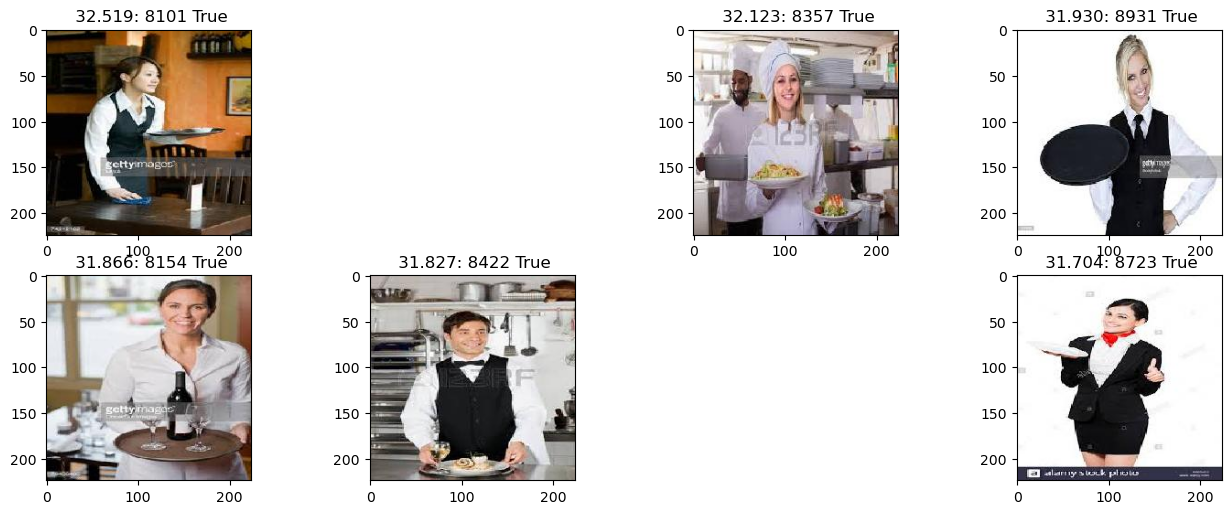

In [503]:
query_dict = {}
profs = copy.deepcopy(iden_prof.professions)
profs.remove('firefighter')
for  k, s in enumerate(similarity_gendered):
    

#     print(s)
#     s = np.asarray(similarity[k])
#     s = np.asarray(s)
#     print(queries[k])
    query_dict[word_list_gendered[k]] = s #similarity[k]
topk = 20
sorted_idx = []
for k in query_dict.keys():

    s = np.asarray(query_dict[k])
    topk_ = int(topk/2)
    ind = s.argsort()[-topk_:][::-1]
    sorted_idx.append(ind)    



for q_idx, (k, s_ind) in enumerate(zip(query_dict.keys(), sorted_idx)):
    if q_idx == 16:
        
        s = np.asarray(query_dict[k])
        print(word_list_gendered[q_idx])
    #     print("top 10", s[s_ind])
        plt.figure(figsize=(16, 25))
        acc = 0
        for topi, idx in enumerate(s_ind):
            
            a = iden_prof[idx][2]
#             print(a, profs[q_idx])
#             print(topi, idx)
            idx_new = int(q_idx/2)
            acc += int(profs[idx_new]== a)
            
            if profs[idx_new] != a:
                continue
            plt.subplot(8, 4, topi + 1 )
            
#             print(profs[q_idx])
            image = io.imread( iden_prof[idx][1])
            pil_image = PIL.Image.fromarray(image)
            plt.imshow(pil_image)
            plt.title(f" {s[s_ind[topi]]:.3f}: {idx} {profs[idx_new]== a}")
        print(f'{acc/topk_:.2f}')
#         if topk==10:
            
#             if idx_new in precision_gen_10:
#                 precision_gen_10[int(q_idx/2)] += acc/topk_
#             else:
#                 precision_gen_10[int(q_idx/2)] = acc/topk_
#         elif topk==20:
#             if idx_new in precision_gen_20:
#                 precision_gen_20[int(q_idx/2)] += acc/topk_
#             else:
#                 precision_gen_20[int(q_idx/2)] = acc/topk_
#         else:
# #             print(topk)
#             if idx_new in precision_gen_30:
#                 precision_gen_30[int(q_idx/2)] += acc/topk_
#             else:
#                 precision_gen_30[int(q_idx/2)] = acc/topk_

In [446]:
precision_gen_10

{0: 2.0, 1: 2.0, 2: 2.0, 3: 2.0, 4: 2.0, 5: 2.0, 6: 2.0, 7: 2.0, 8: 1.8}

In [465]:
precision_gen_20

{0: 1.8, 1: 2.0, 2: 2.0, 3: 2.0, 4: 2.0, 5: 2.0, 6: 2.0, 7: 2.0, 8: 1.6}

In [512]:
print(f'{np.mean(np.asarray(list(precision_gen_10.values()))/2):.2f}', f'{stats.sem(np.asarray(list(precision_gen_10.values()))/2)*2:.2f}')
print(f'{np.mean(np.asarray(list(precision_gen_20.values()))/2):.2f}', f'{stats.sem(np.asarray(list(precision_gen_20.values()))/2)*2:.2f}')
print(f'{np.mean(np.asarray(list(precision_gen_30.values()))/2):.2f}', f'{stats.sem(np.asarray(list(precision_gen_30.values()))/2)*2:.2f}')
# print(f'{np.mean(list(precision_prompt_20.values())):.2f}', f'{stats.sem(list(precision_prompt_20.values()))*2:.2f}')
# print(f'{np.mean(list(precision_prompt_30.values())):.2f}', f'{stats.sem(list(precision_prompt_30.values()))*2:.2f}')

0.99 0.02
0.97 0.05
0.97 0.05


In [514]:
m = np.mean(abs(np.asarray([5,5,4,5,6,6,4,4,0]) - np.asarray([5,5,6,5,4,4,6,6,9])) / (np.asarray(list(precision_gen_10.values()))* 5))
s = stats.sem(abs(np.asarray([5,5,4,5,6,6,4,4,0]) - np.asarray([5,5,6,5,4,4,6,6,9])) / (np.asarray(list(precision_gen_10.values()))* 5))
print(f'{m:.2f}\u00B1{s:.2f}')

m = np.mean(abs(np.asarray([11,10,8,11,11,11,9,9,1]) - np.asarray([7,10,11,8,9,8,11,11,13])) / (np.asarray(list(precision_gen_20.values()))* 10))
s = stats.sem(abs(np.asarray([11,10,8,11,11,11,9,9,1]) - np.asarray([7,10,11,8,9,8,11,11,13])) / (np.asarray(list(precision_gen_20.values()))* 10))
print(f'{m:.2f}\u00B1{s:.2f}')

m = np.mean(abs(np.asarray([16,13,11,15,19,17,13,13,1]) - np.asarray([9,16,17,13,11,9,16,17,19])) / (np.asarray(list(precision_gen_30.values()))* 15))
s = stats.sem(abs(np.asarray([16,13,11,15,19,17,13,13,1]) - np.asarray([9,16,17,13,11,9,16,17,19])) / (np.asarray(list(precision_gen_30.values()))* 15))
print(f'{m:.2f}\u00B1{s:.2f}')

0.22±0.10
0.19±0.07
0.24±0.07


In [515]:
abs(np.asarray([16,13,11,15,19,17,13,13,1]) - np.asarray([9,16,17,13,11,9,16,17,19])) / (np.asarray(list(precision_gen_30.values()))* 15)

array([0.25      , 0.1       , 0.2       , 0.06666667, 0.26666667,
       0.26666667, 0.1       , 0.13333333, 0.7826087 ])

In [519]:
(16 - 9) / 28

0.25

In [517]:
precision_gen_30

{0: 1.8666666666666667,
 1: 2.0,
 2: 2.0,
 3: 2.0,
 4: 2.0,
 5: 2.0,
 6: 2.0,
 7: 2.0,
 8: 1.5333333333333332}